In [1]:
import pandas as pd
import numpy as np
import datetime
pd.set_option('display.max_rows', 100)

%load_ext autoreload

In [2]:
from charts import plot_line
from charts import plot_bar
from features import add_variables_covid
from features import add_variables_apple

%matplotlib inline

In [3]:
date_apple = '2020-04-28'

# World Bank Data

In [4]:
import world_bank_data as wb

In [5]:
countries = wb.get_countries()

In [6]:
# population = wb.get_series('SP.POP.TOTL', mrv=1)  # Most recent value
population = wb.get_series('SP.POP.TOTL', id_or_value='id', simplify_index=True, mrv=1)

In [7]:
# Aggregate region, country and population
df_population = countries[['region', 'name']].rename(columns={'name': 'country'}).loc[countries.region != 'Aggregates']
df_population['population'] = population
df_population.head(1)

,region,country,population
id,,,
ABW,Latin America & Caribbean,Aruba,105845.0


In [8]:
def apple_filter_region(df, region):
    df_region = df[df.region == region].T
    df_region.columns = df_region.loc['transportation_type', :]
    df_region = df_region[~df_region.index.isin(['geo_type', 'region', 'transportation_type', 'alternative_name'])]
    
    df_region['dates'] = pd.to_datetime(df_region.index)
    df_region.set_index('dates', inplace=True)
    df_region = df_region.astype('float')
    
    return df_region

In [9]:
date_now = datetime.datetime.strftime(datetime.datetime.utcnow(), "%Y-%m-%d")

dfapple = pd.read_csv(f"data/AppleMobilty/applemobilitytrends-{date_apple}.csv")

dfcovid_conf = pd.read_csv("data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
dfcovid_dead = pd.read_csv("data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

df_rki_germany = pd.read_csv("data/RKI-reports.csv")

### Add index to RKI data

In [10]:
df_rki_germany['date'] = df_rki_germany['date'].astype('datetime64[ns]')
df_rki_germany = df_rki_germany.sort_values('date', ascending=True)
df_rki_germany.set_index('date', inplace=True)

### Transpose Confirmed Cases

In [11]:
dfcovid_conf_t = dfcovid_conf.T
dfcovid_conf_t.columns = dfcovid_conf_t.loc['Country/Region', :] + "_" + dfcovid_conf_t.loc['Province/State', :].astype(str)

dfcovid_conf_t.drop(['Country/Region'], axis=0, inplace=True)

df_country_coords = dfcovid_conf_t.loc[['Lat', 'Long'], :]

dfcovid_conf_t.drop(['Lat', 'Long', 'Province/State'], axis=0, inplace=True)
dfcovid_conf_t['dates'] = dfcovid_conf_t.index
dfcovid_conf_t['dates'] = dfcovid_conf_t['dates'].astype('datetime64[ns]')
dfcovid_conf_t = dfcovid_conf_t.sort_values('dates', ascending=True)
dfcovid_conf_t.set_index('dates', inplace=True)
dfcovid_conf_t = dfcovid_conf_t.astype(float)

### Transpose Dead Cases

In [12]:
dfcovid_dead_t = dfcovid_dead.T
dfcovid_dead_t.columns = dfcovid_dead_t.loc['Country/Region', :] + "_" + dfcovid_dead_t.loc['Province/State', :].astype(str)
dfcovid_dead_t.drop(['Country/Region'], axis=0, inplace=True)


dfcovid_dead_t.drop(['Lat', 'Long', 'Province/State'], axis=0, inplace=True)
dfcovid_dead_t['dates'] = dfcovid_dead_t.index
dfcovid_dead_t['dates'] = dfcovid_dead_t['dates'].astype('datetime64[ns]')
dfcovid_dead_t = dfcovid_dead_t.sort_values('dates', ascending=True)
dfcovid_dead_t.set_index('dates', inplace=True)
dfcovid_dead_t = dfcovid_dead_t.astype(float)


In [13]:
# import inspect
# source_DF = inspect.getsource(add_weekday_weekend)
# print(source_DF)

# Apple Mobility DF

## Transpose Mobility and Filter Region Create lagged and % variables

In [14]:
dfapple_region = apple_filter_region(dfapple, "Hamburg").copy()
dfapple_region = add_variables_apple(dfapple_region)

In [15]:
print("Mobility max date:", max(dfapple_region.index))
print("Covi world max date", max(dfcovid_conf_t.index))
print("Covi world max date", max(dfcovid_dead_t.index))
print("RKI max date", max(df_rki_germany.index))

Mobility max date: 2020-04-28 00:00:00
Covi world max date 2020-04-29 00:00:00
Covi world max date 2020-04-29 00:00:00
RKI max date 2020-04-29 00:00:00


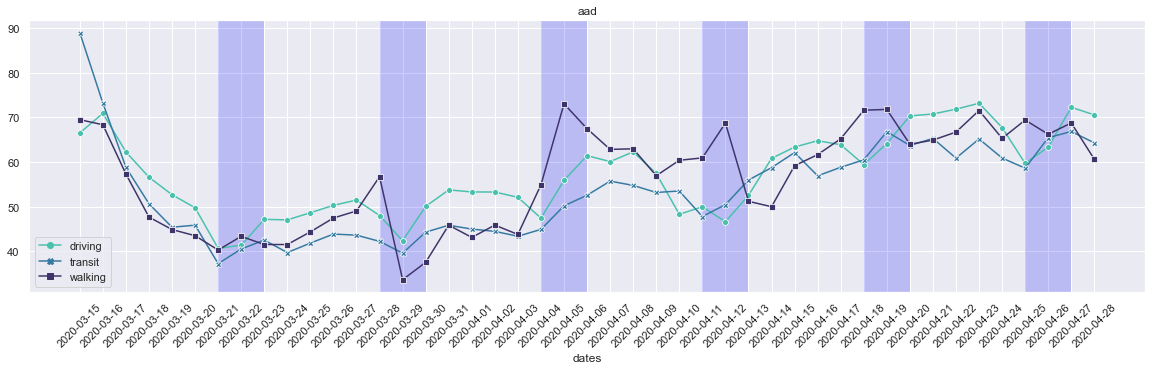

In [16]:
plot_line(dfapple_region, columns=['driving','transit','walking'], date_cutoff='2020-03-15', title='aad')

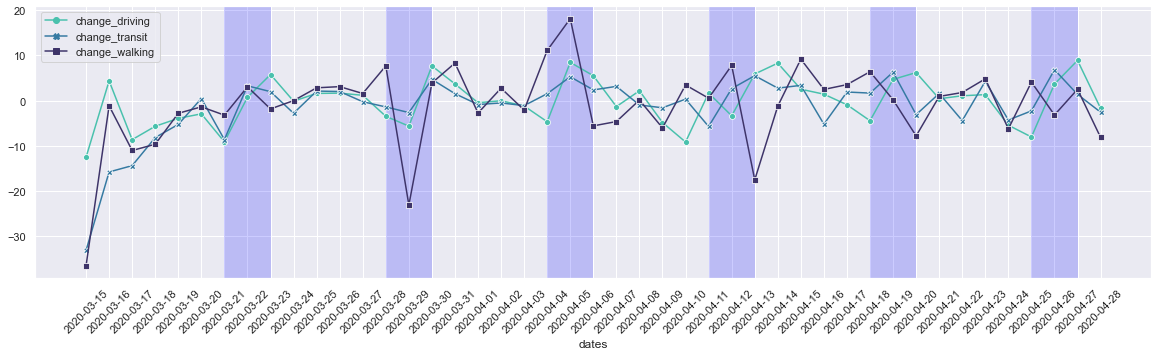

In [17]:
plot_line(dfapple_region, columns=['change_driving', 'change_transit', 'change_walking'], date_cutoff='2020-03-15')

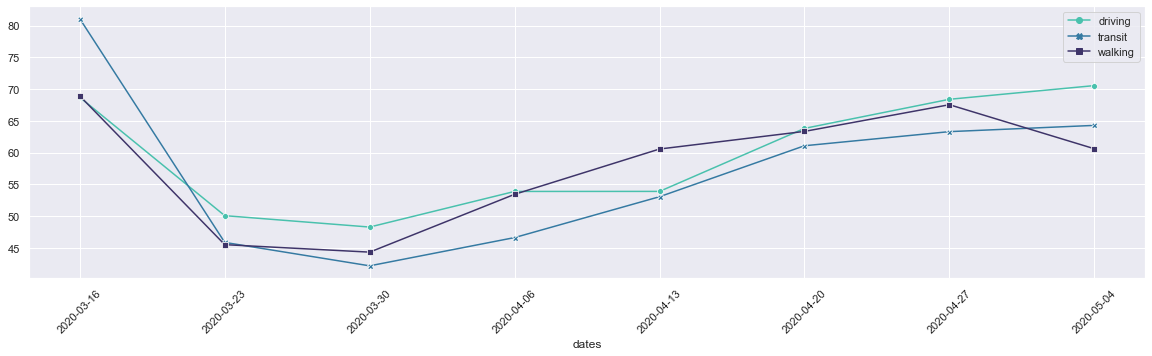

In [18]:
plot_line(dfapple_region, columns=['driving','transit','walking'], resample='W-MON', date_cutoff='2020-03-15')

# Robert Koch Institute DF

## Filter region (Hamburg) & Create lagged and % variables

In [19]:
df_hamburg = df_rki_germany.loc[df_rki_germany.land == 'Hamburg', :].copy()
df_hamburg.drop('data', axis=1, inplace=True)

df_hamburg = add_variables_covid(df_hamburg, 'confirmed', population=1822000)
df_hamburg = add_variables_covid(df_hamburg, 'dead', population=1822000)

In [20]:
df_berlin = df_rki_germany.loc[df_rki_germany.land == 'Berlin', :].copy()
df_berlin.drop('data', axis=1, inplace=True)

df_berlin = add_variables_covid(df_berlin, 'confirmed', population=3769000)
df_berlin = add_variables_covid(df_berlin, 'dead', population=3769000)

In [21]:
def prepare_df_country(df_confirmed, df_dead, country, country_code, date_cutoff='2020-03-15'):
    df = df_confirmed.loc[df_confirmed.index >= date_cutoff, [country]]
    df.columns = ['confirmed']
    df = add_variables_covid(df, population=population[country_code])

    df_d = df_dead.loc[df_dead.index >= date_cutoff, [country]]
    df_d.columns = ['dead']
    df = df.merge(df_d, left_index=True, right_index=True)
    df = add_variables_covid(df, column='dead', population=population[country_code])
    
    return df

In [22]:
def print_charts_country(df, date_cutoff='2020-03-15'):
    plot_bar(df, columns='confirmed', date_cutoff=date_cutoff)
    plot_bar(df, columns='confirmed_change', date_cutoff=date_cutoff)
    # plot_line(df, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff=date_cutoff)
    plot_line(df, columns=['confirmed_doubling_days', 'confirmed_doubling_days_3w', 'confirmed_doubling_days_3w_avg3'], date_cutoff=date_cutoff)
    plot_line(df, columns=['dead_doubling_days', 'dead_doubling_days_3w', 'dead_doubling_days_3w_avg3'], date_cutoff=date_cutoff)
    # plot_line(df, columns=['confirmed_change_acceleration_avg3'], date_cutoff=date_cutoff')


----

In [23]:
# df_hamburg.sort_index(ascending=False).head(5).T

# Explore Plots

# Hamburg

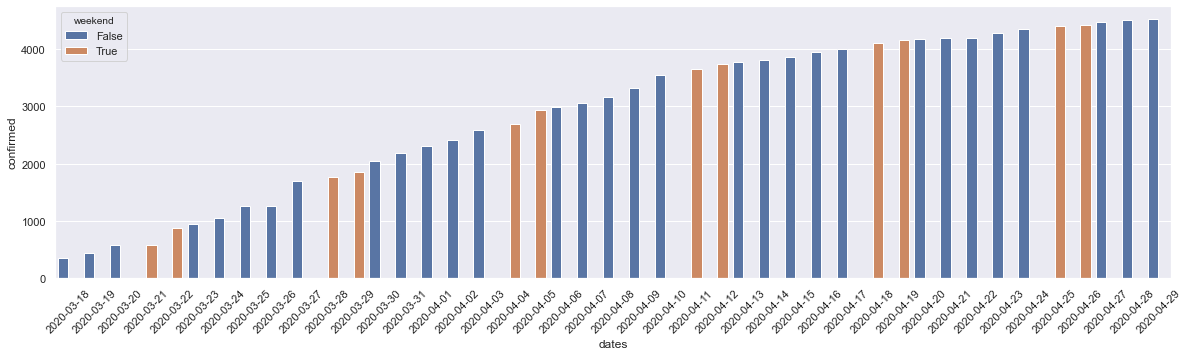

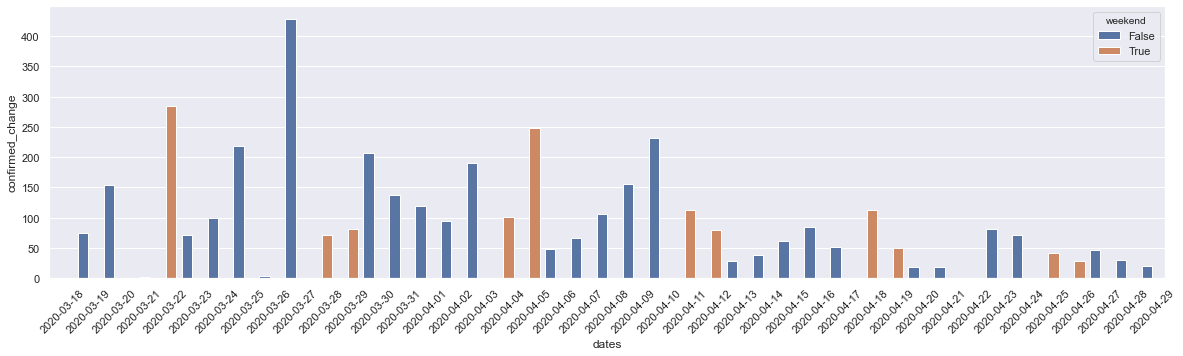

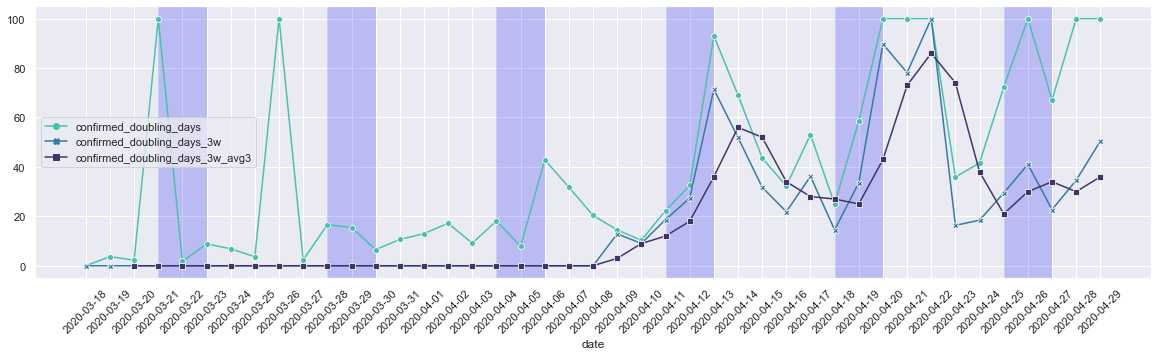

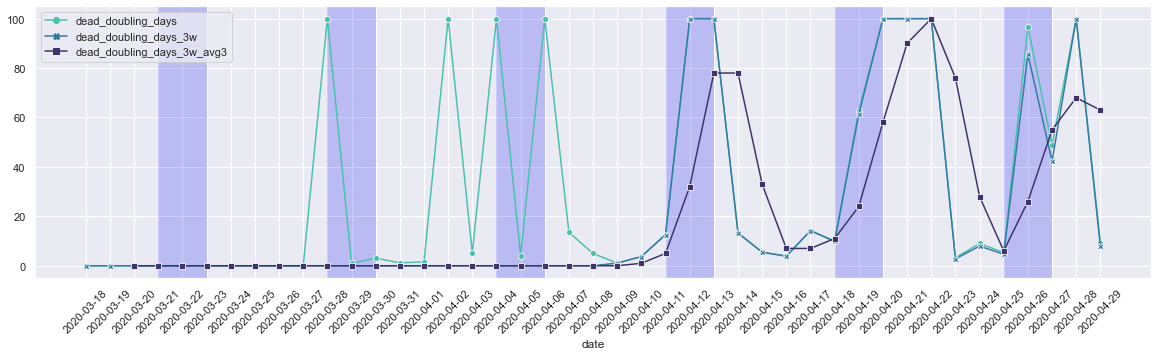

In [24]:
print_charts_country(df_hamburg)

# Berlin

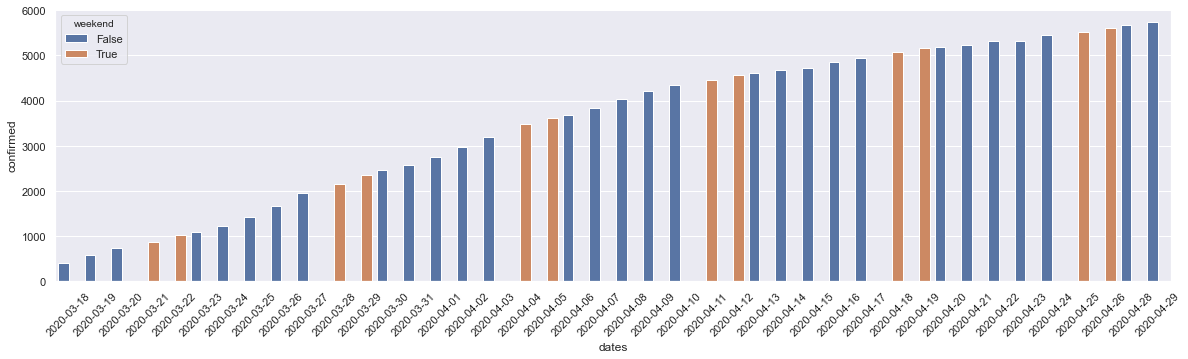

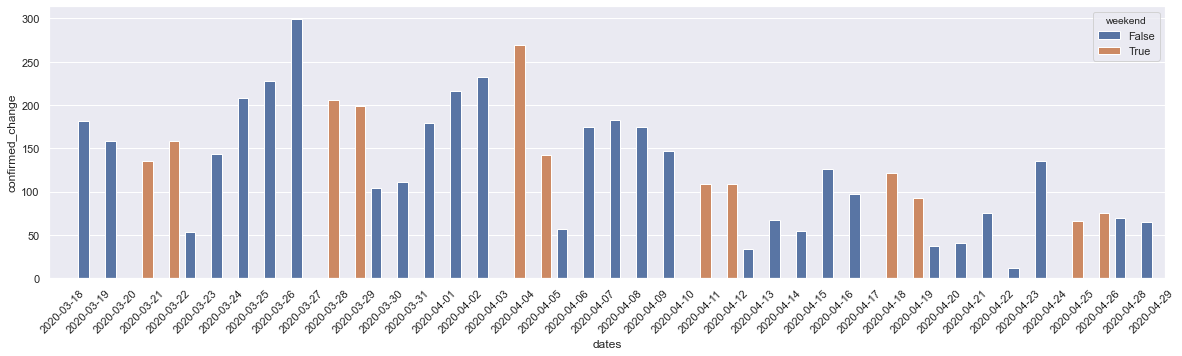

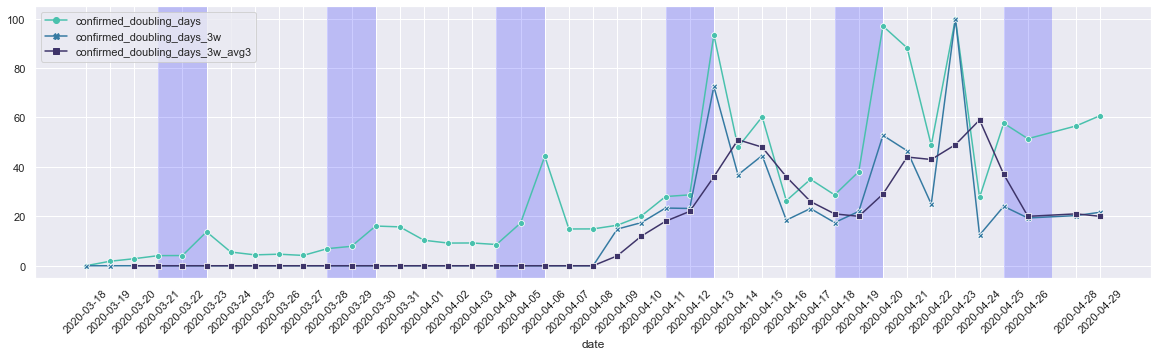

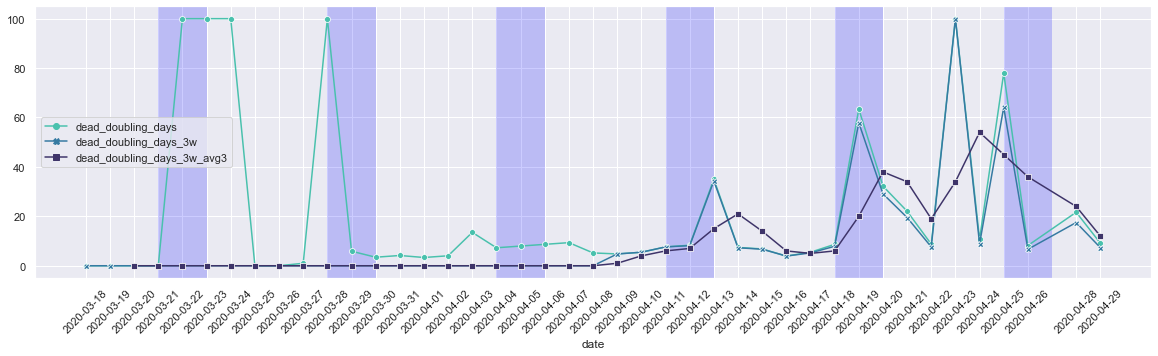

In [25]:
print_charts_country(df_berlin)

# Russia

In [26]:
df_russia = prepare_df_country(dfcovid_conf_t, dfcovid_dead_t, 'Russia_nan', country_code='RUS', date_cutoff='2020-03-15')

In [151]:
def add_forecast_prophet(df_in, column, window=60, ):
    from fbprophet import Prophet
    df = df_in.loc[:, [column]].dropna()
    df['ds'] = df.index
    df.columns = ['y', 'ds']
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=window)
    forecast = m.predict(future)
    forecast.set_index(forecast.ds, inplace=True)
    forecast = forecast.loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
    df_extra_dates = pd.DataFrame({ 'day': pd.Series([max(df_in.index) + datetime.timedelta(1), max(df_in.index) + datetime.timedelta(window)])})
    df_extra_dates.set_index('day',inplace=True)
    df_extra_dates = df_extra_dates.asfreq('D')
    df_in = df_in.append(df_extra_dates)
    df_result = pd.concat([df_in, forecast ], axis=1)
    df_result[f'{column}_pred'] = df_result.loc[df_result[column].isnull() == True, ['yhat']]
    
    return df_result


In [152]:
df = add_forecast_prophet(df_russia, 'confirmed_peak', 35)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


In [ ]:
plot_line(df, columns=['confirmed_peak', 'yhat'], title='Russia: Peak', date_cutoff='2020-04-15')


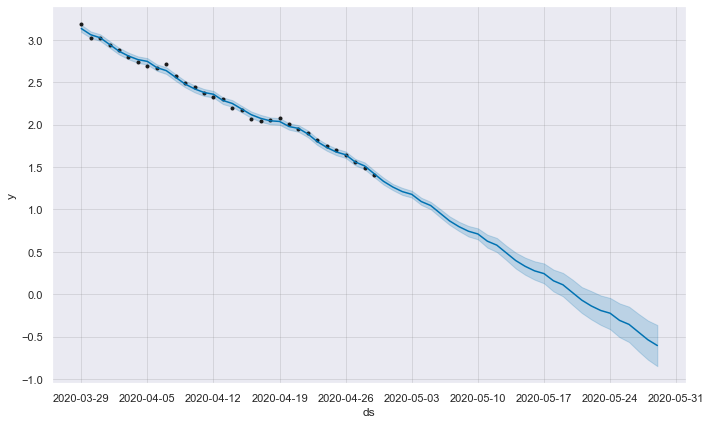

In [72]:
fig1 = m.plot(forecast)


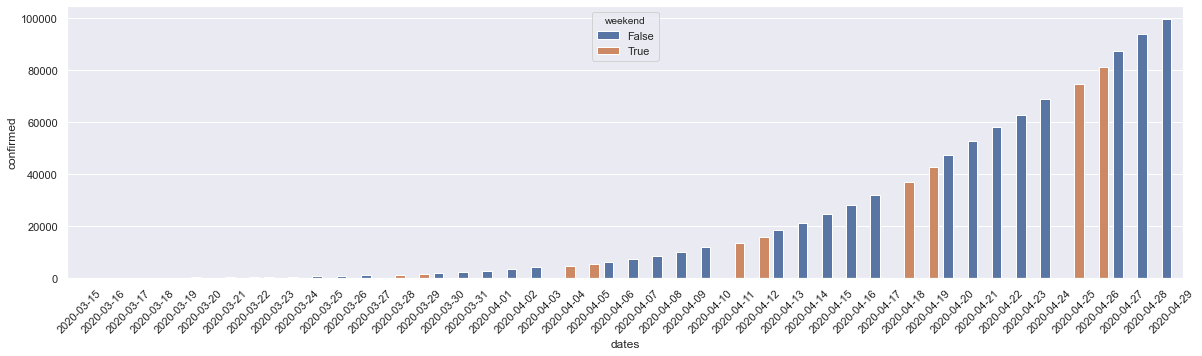

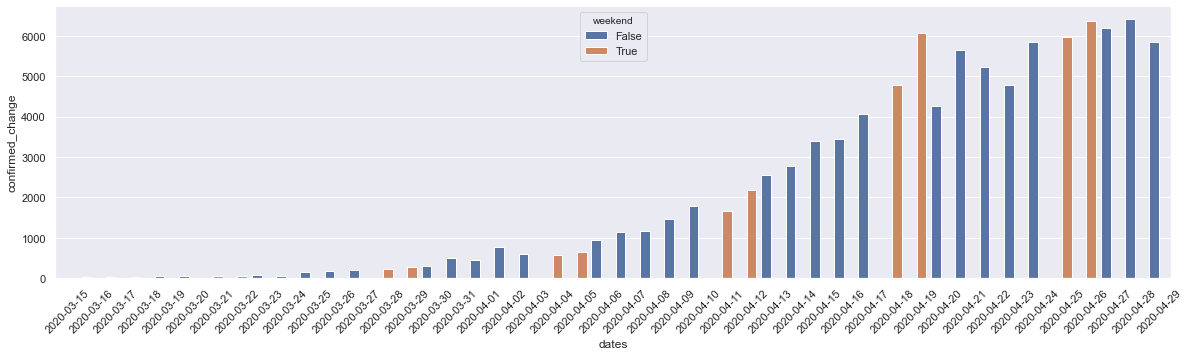

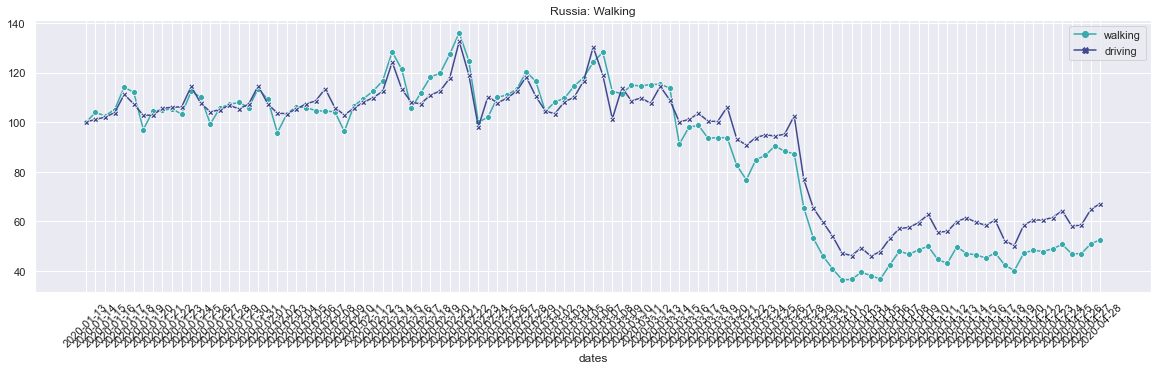

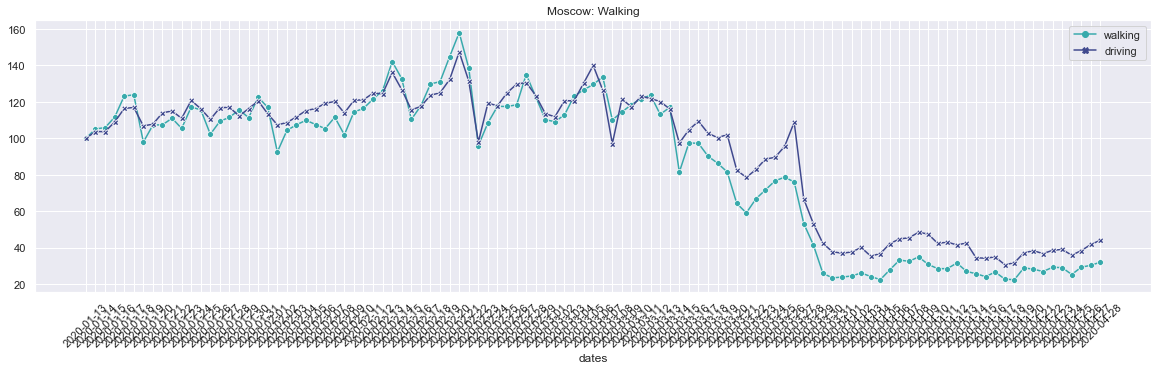

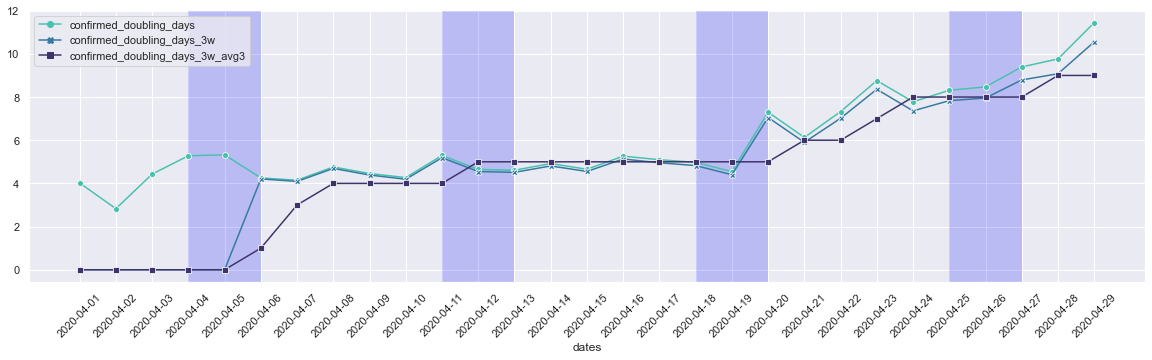

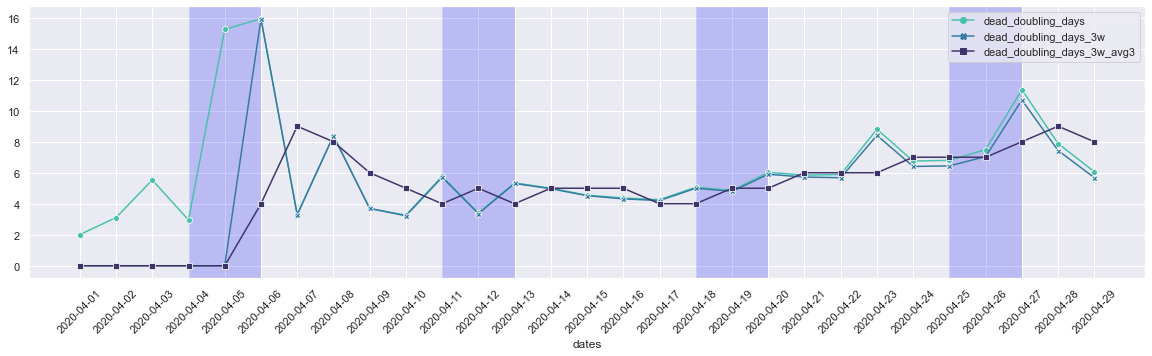

In [27]:
plot_bar(df_russia, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_russia, columns='confirmed_change', date_cutoff='2020-03-15')
plot_line(apple_filter_region(dfapple, "Russia"), columns=['walking','driving'], title='Russia: Walking')
plot_line(apple_filter_region(dfapple, "Moscow"), columns=['walking','driving'], title='Moscow: Walking')
plot_line(df_russia, columns=['confirmed_doubling_days', 'confirmed_doubling_days_3w', 'confirmed_doubling_days_3w_avg3'], date_cutoff='2020-04-01')
plot_line(df_russia, columns=['dead_doubling_days', 'dead_doubling_days_3w', 'dead_doubling_days_3w_avg3'], date_cutoff='2020-04-01')


# Sweden

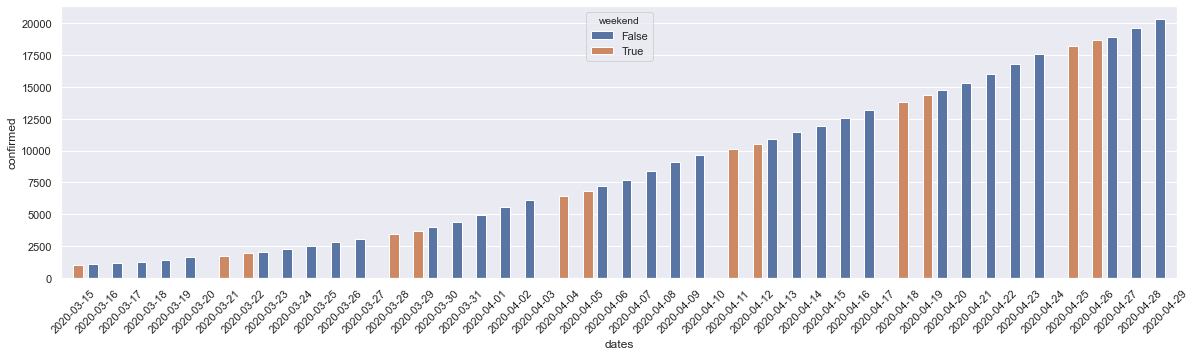

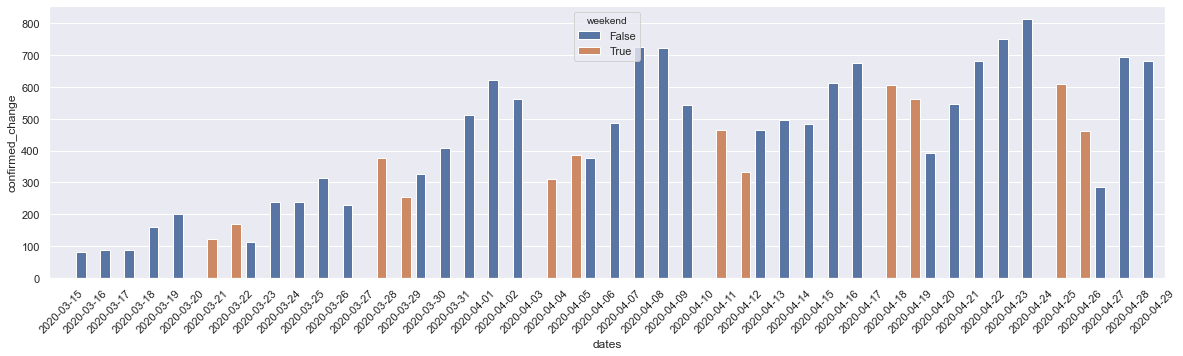

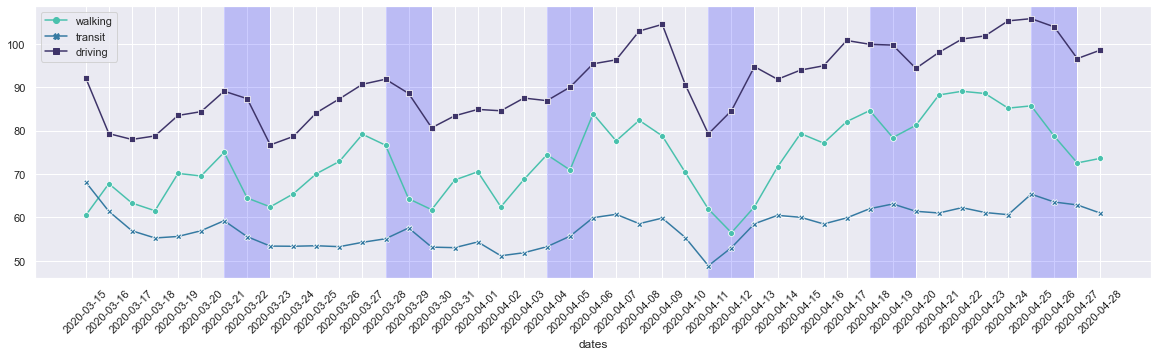

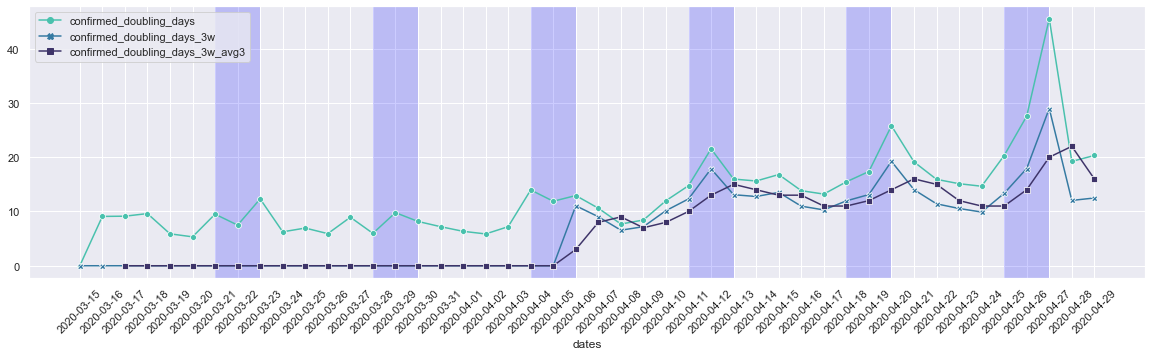

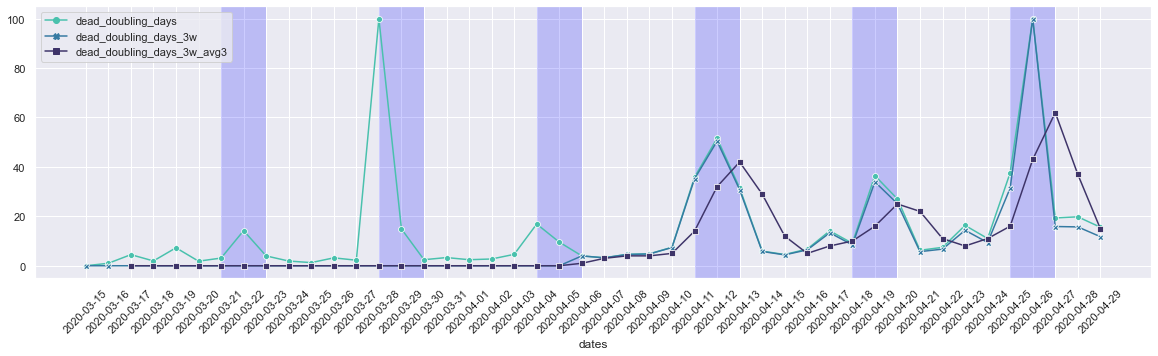

In [28]:
df_sweden = prepare_df_country(dfcovid_conf_t, dfcovid_dead_t, 'Sweden_nan', country_code='SWE', date_cutoff='2020-03-15')

plot_bar(df_sweden, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_sweden, columns='confirmed_change', date_cutoff='2020-03-15')
plot_line(apple_filter_region(dfapple, "Sweden"), columns=['walking', 'transit','driving'], date_cutoff='2020-03-15')
# plot_line(df_sweden, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-03-15')
plot_line(df_sweden, columns=['confirmed_doubling_days', 'confirmed_doubling_days_3w', 'confirmed_doubling_days_3w_avg3'], date_cutoff='2020-03-01')
plot_line(df_sweden, columns=['dead_doubling_days', 'dead_doubling_days_3w', 'dead_doubling_days_3w_avg3'], date_cutoff='2020-03-01')
# plot_line(df_sweden, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-03-01')

# UK

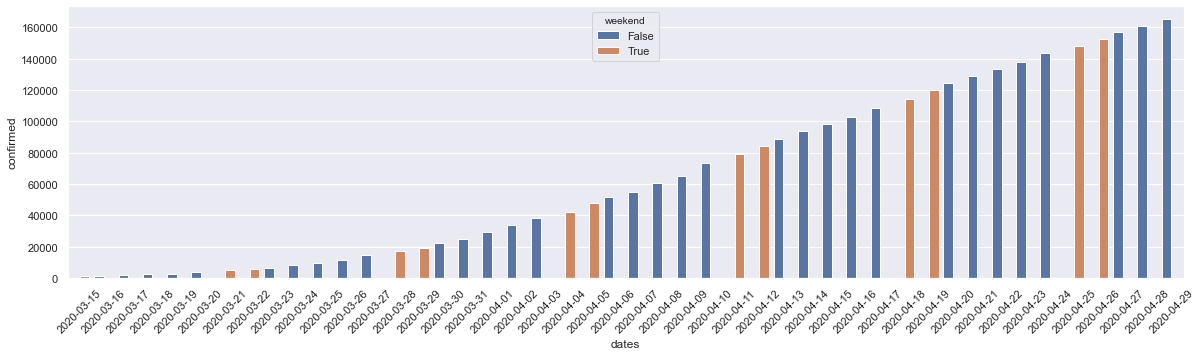

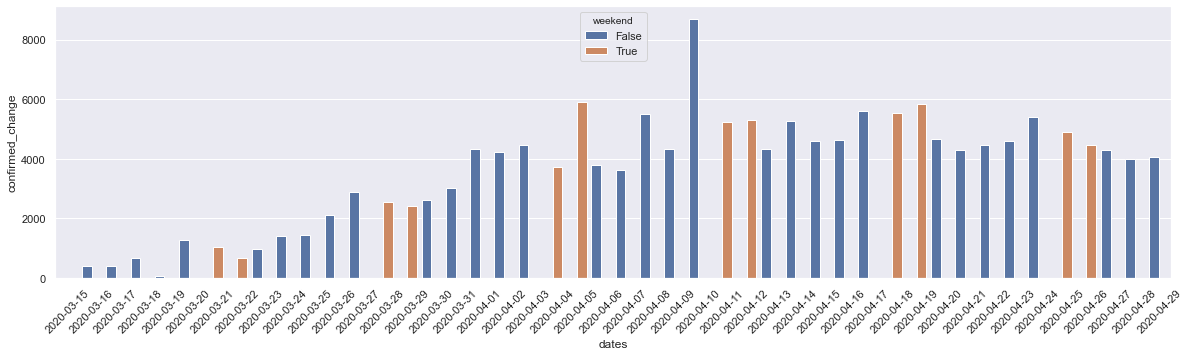

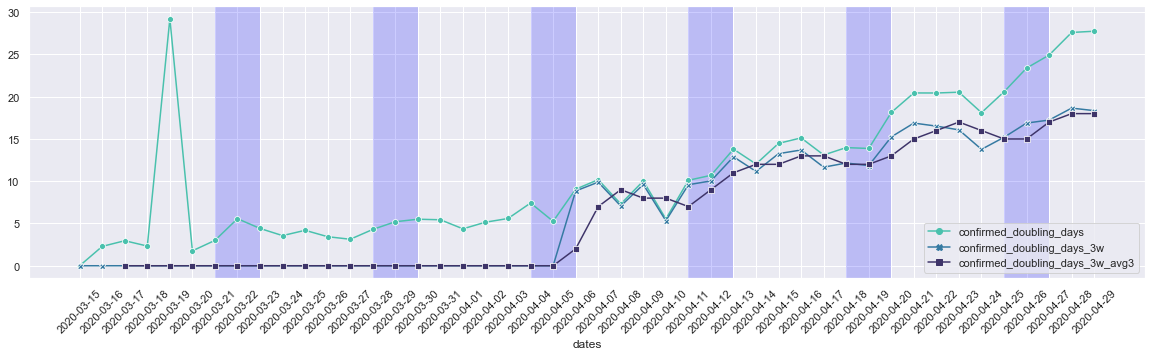

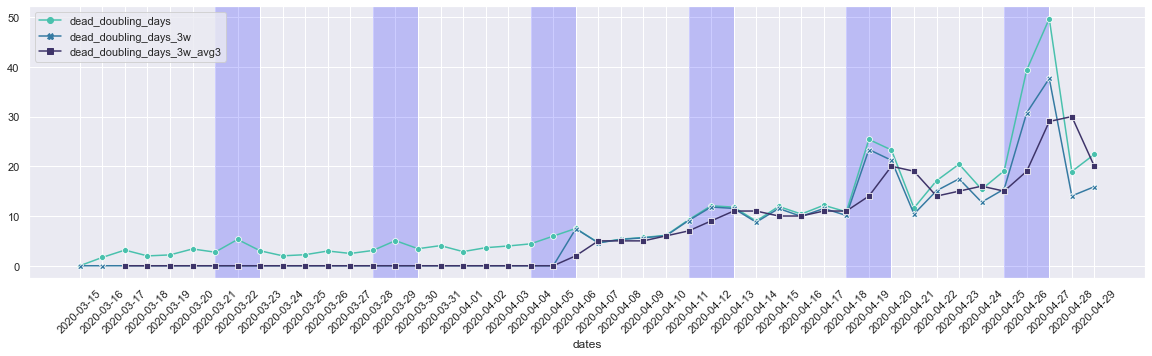

In [29]:
df_uk = prepare_df_country(dfcovid_conf_t, dfcovid_dead_t, 'United Kingdom_nan', country_code='GBR', date_cutoff='2020-03-15')

plot_bar(df_uk, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_uk, columns='confirmed_change', date_cutoff='2020-03-15')
# plot_line(df_uk, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-03-15')
plot_line(df_uk, columns=['confirmed_doubling_days', 'confirmed_doubling_days_3w', 'confirmed_doubling_days_3w_avg3'], date_cutoff='2020-03-01')
plot_line(df_uk, columns=['dead_doubling_days', 'dead_doubling_days_3w', 'dead_doubling_days_3w_avg3'], date_cutoff='2020-03-01')
# plot_line(df_uk, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-03-01')

# US

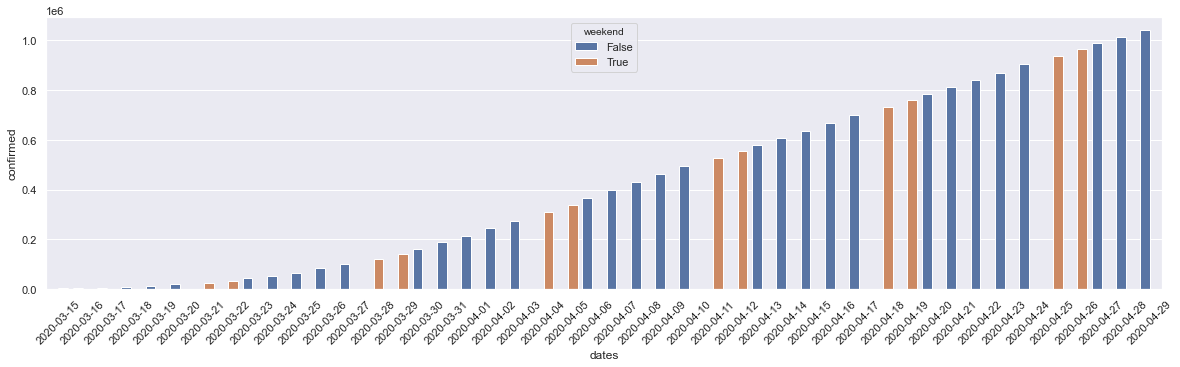

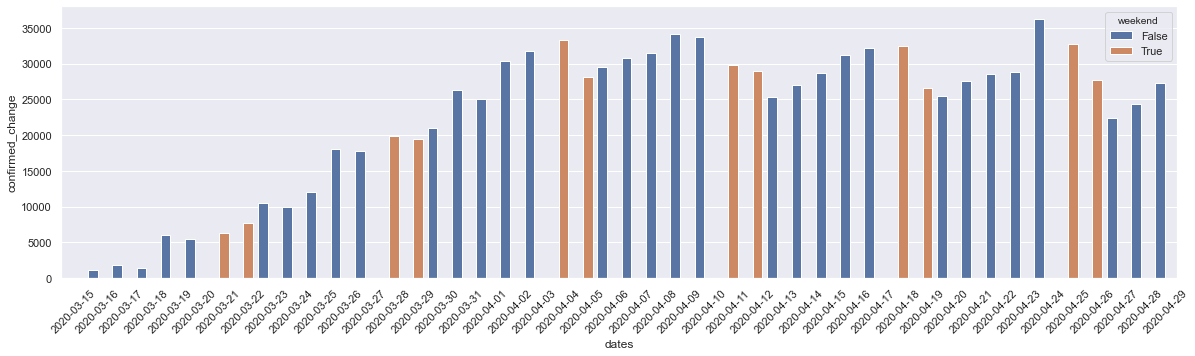

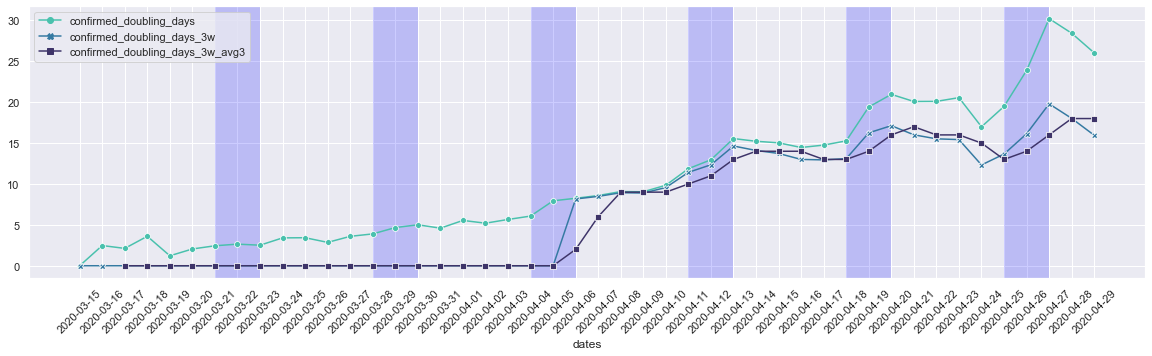

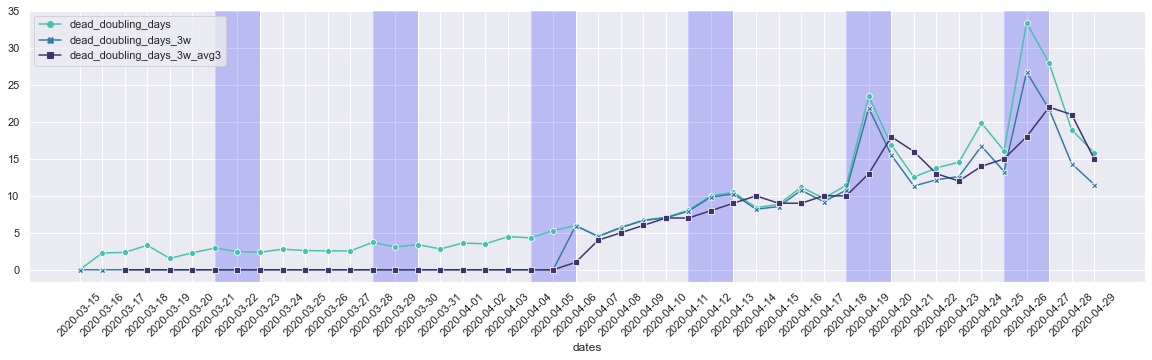

In [30]:
df_us = prepare_df_country(dfcovid_conf_t, dfcovid_dead_t, 'US_nan', country_code='USA', date_cutoff='2020-03-15')

plot_bar(df_us, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_us, columns='confirmed_change', date_cutoff='2020-03-15')
# plot_line(df_uk, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-03-15')
plot_line(df_us, columns=['confirmed_doubling_days', 'confirmed_doubling_days_3w', 'confirmed_doubling_days_3w_avg3'], date_cutoff='2020-03-01')
plot_line(df_us, columns=['dead_doubling_days', 'dead_doubling_days_3w', 'dead_doubling_days_3w_avg3'], date_cutoff='2020-03-01')
# plot_line(df_uk, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-03-01')

# Germany

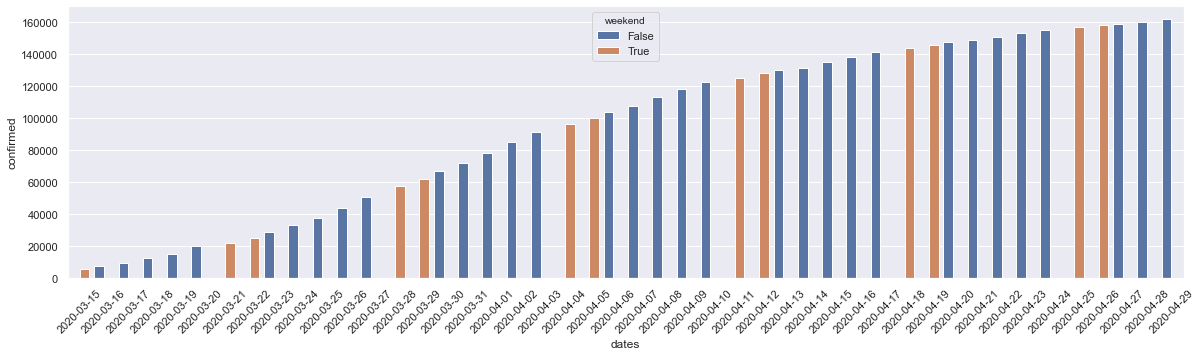

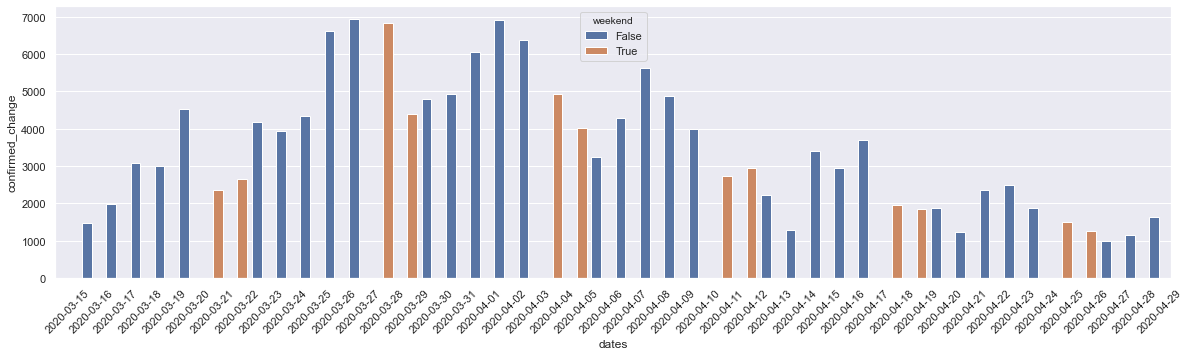

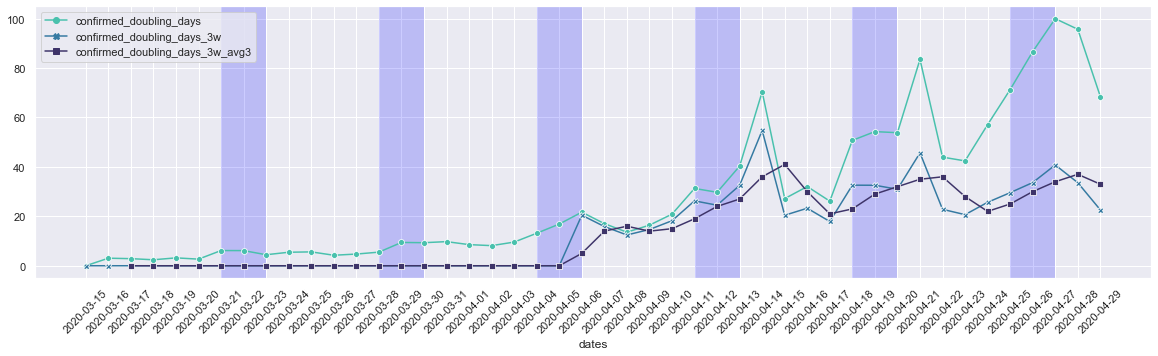

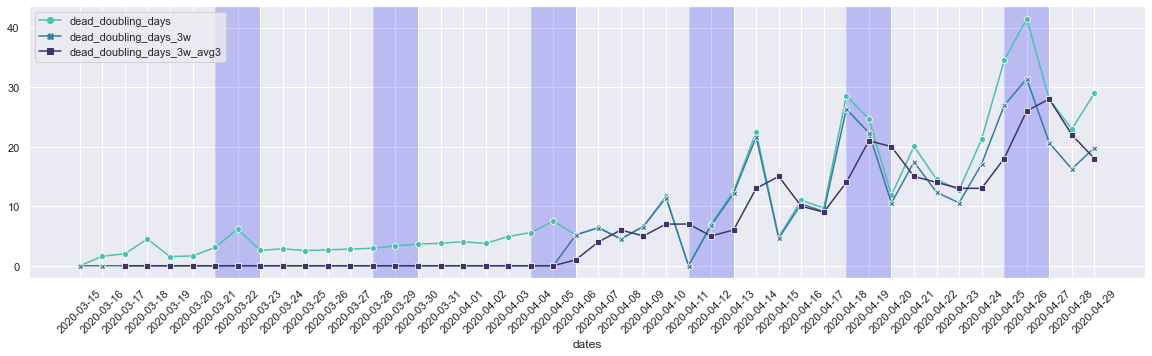

In [31]:
df_germany = prepare_df_country(dfcovid_conf_t, dfcovid_dead_t, 'Germany_nan', country_code='DEU', date_cutoff='2020-03-15')

plot_bar(df_germany, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_germany, columns='confirmed_change', date_cutoff='2020-03-15')
# plot_line(df_germany, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-03-15')
plot_line(df_germany, columns=['confirmed_doubling_days', 'confirmed_doubling_days_3w', 'confirmed_doubling_days_3w_avg3'], date_cutoff='2020-03-01')
plot_line(df_germany, columns=['dead_doubling_days', 'dead_doubling_days_3w', 'dead_doubling_days_3w_avg3'], date_cutoff='2020-03-01')
# plot_line(df_germany, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-03-01')


# France

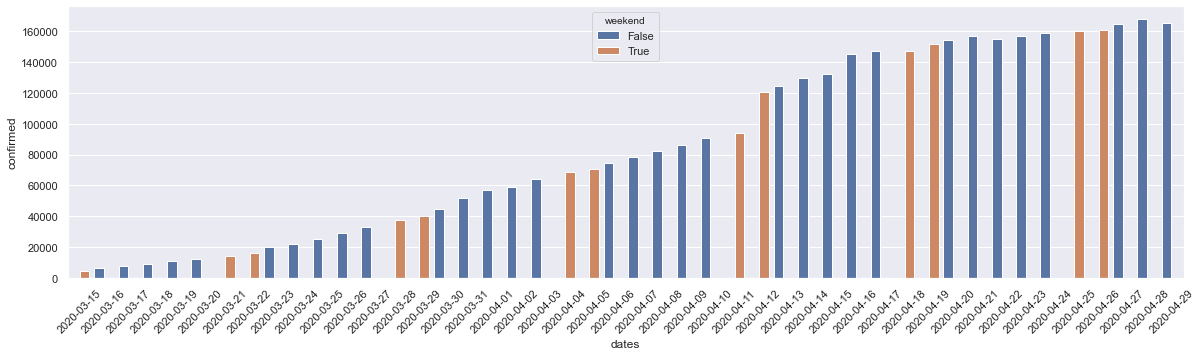

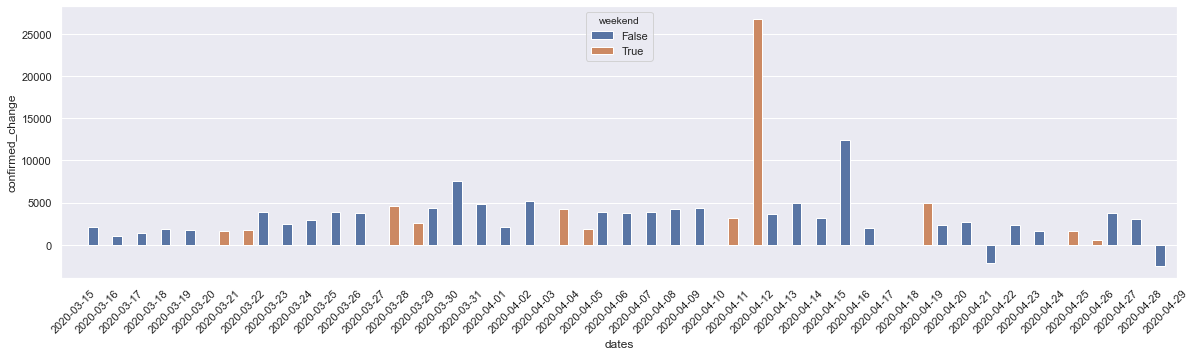

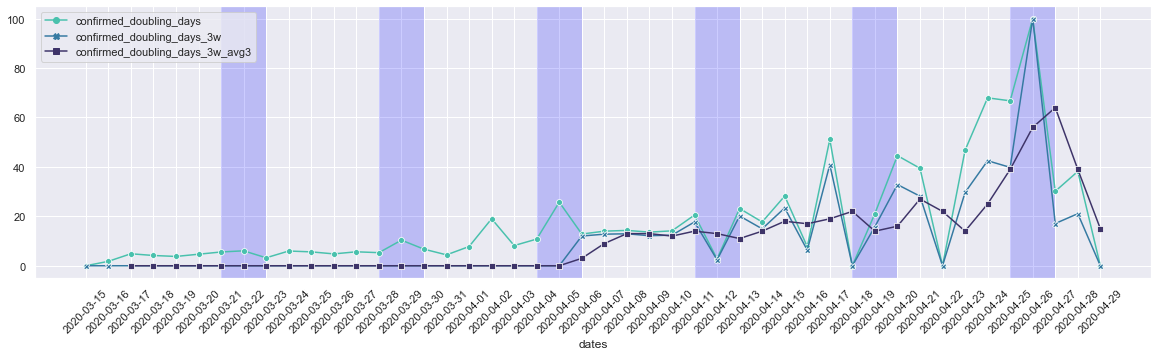

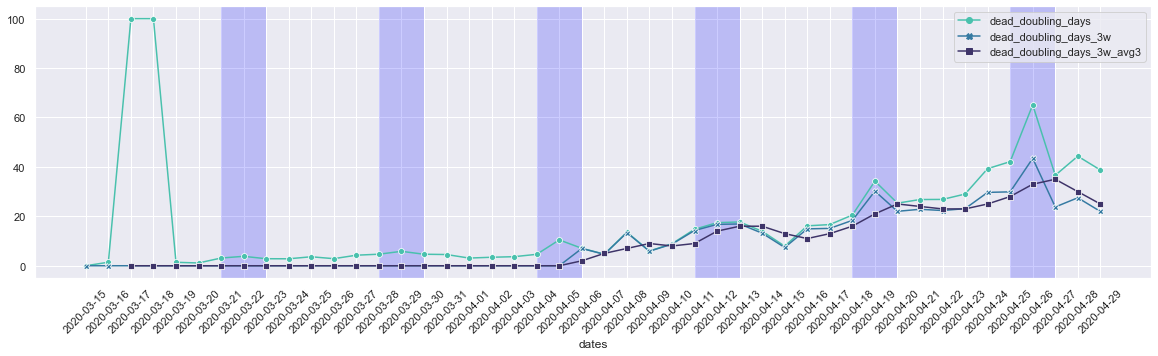

In [32]:
df_france = prepare_df_country(dfcovid_conf_t, dfcovid_dead_t, 'France_nan', country_code='FRA', date_cutoff='2020-03-15')

plot_bar(df_france, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_france, columns='confirmed_change', date_cutoff='2020-03-15')
# plot_line(df_france, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-03-15')
plot_line(df_france, columns=['confirmed_doubling_days', 'confirmed_doubling_days_3w', 'confirmed_doubling_days_3w_avg3'], date_cutoff='2020-03-01')
plot_line(df_france, columns=['dead_doubling_days', 'dead_doubling_days_3w', 'dead_doubling_days_3w_avg3'], date_cutoff='2020-03-01')
# plot_line(df_france, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-03-01')


# Spain

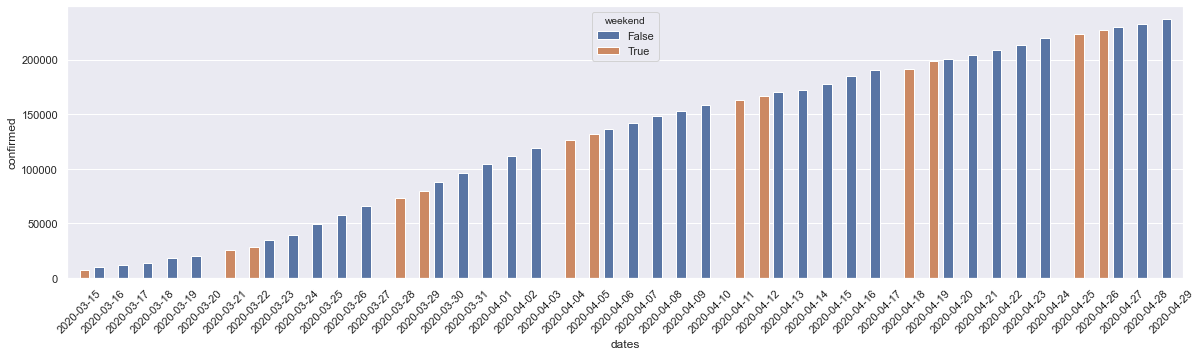

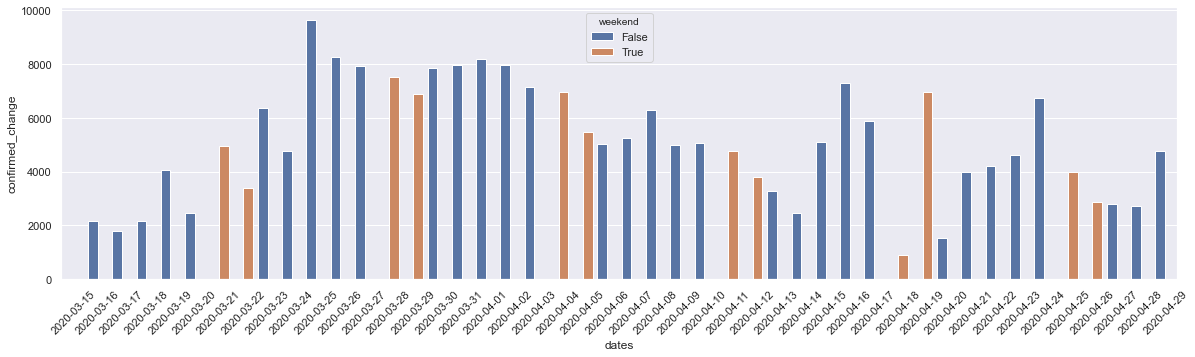

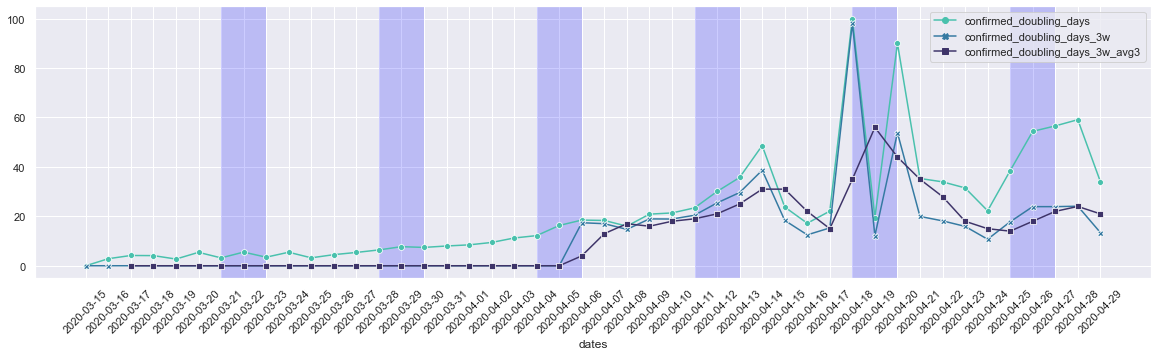

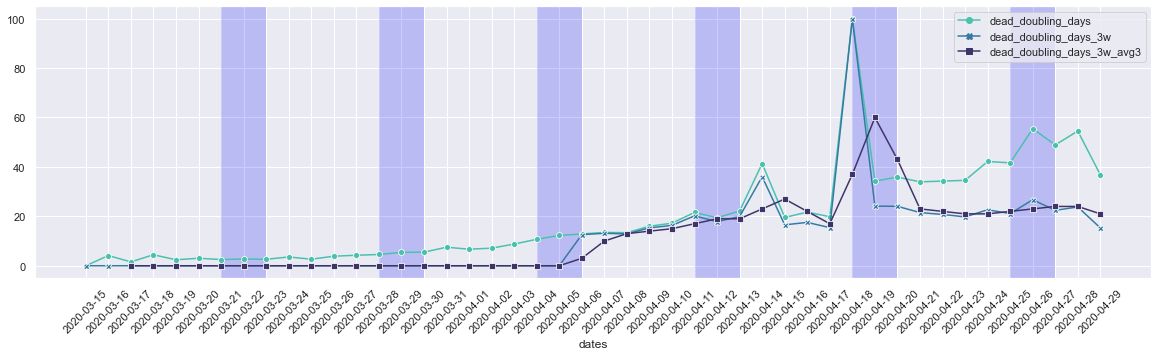

In [33]:
df_spain = prepare_df_country(dfcovid_conf_t, dfcovid_dead_t, 'Spain_nan', country_code='ESP',
                               date_cutoff='2020-03-15')
print_charts_country(df_spain)

# Italy

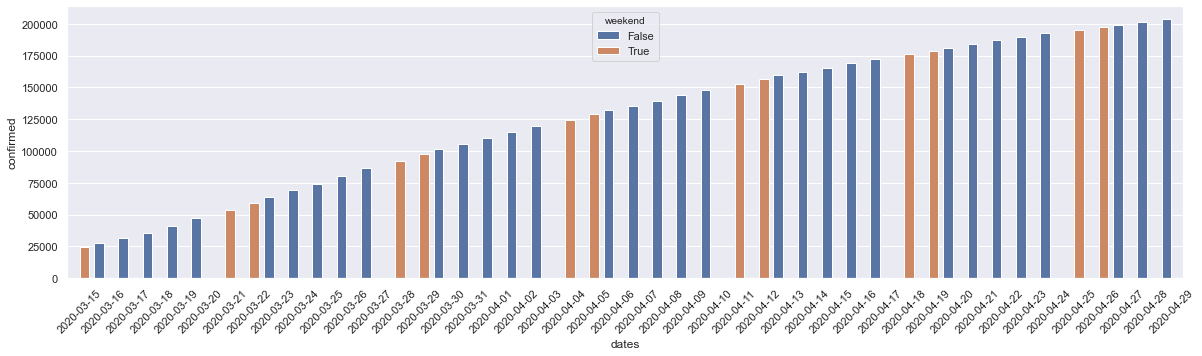

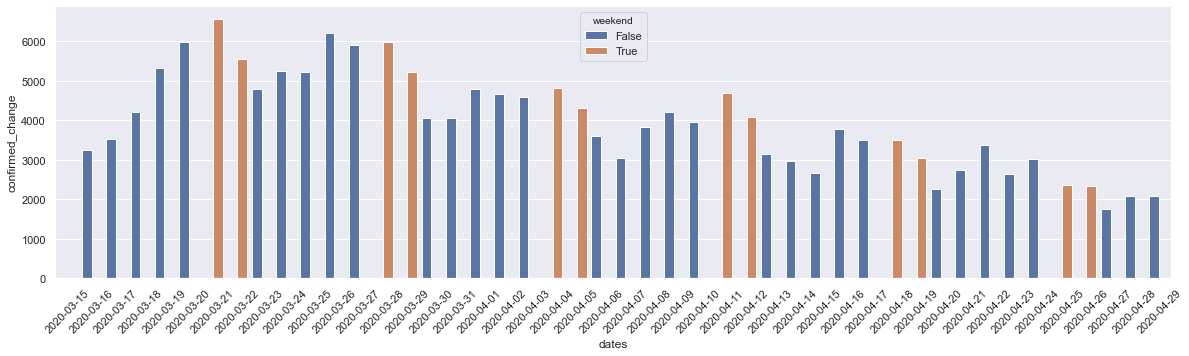

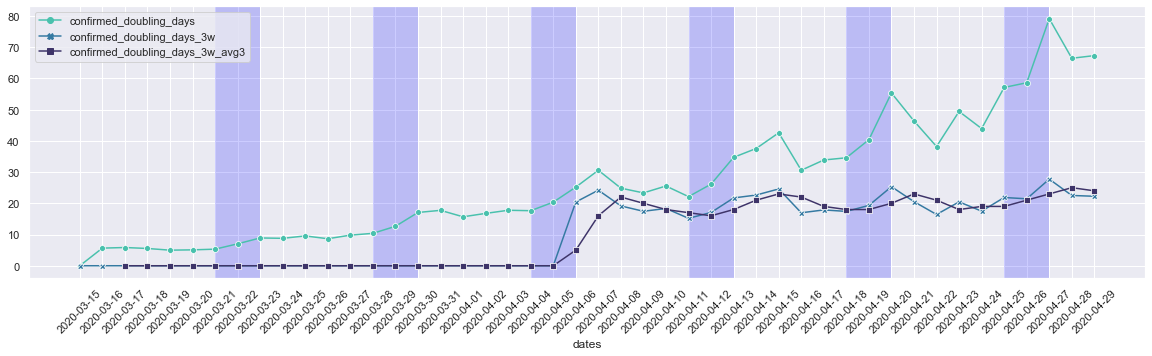

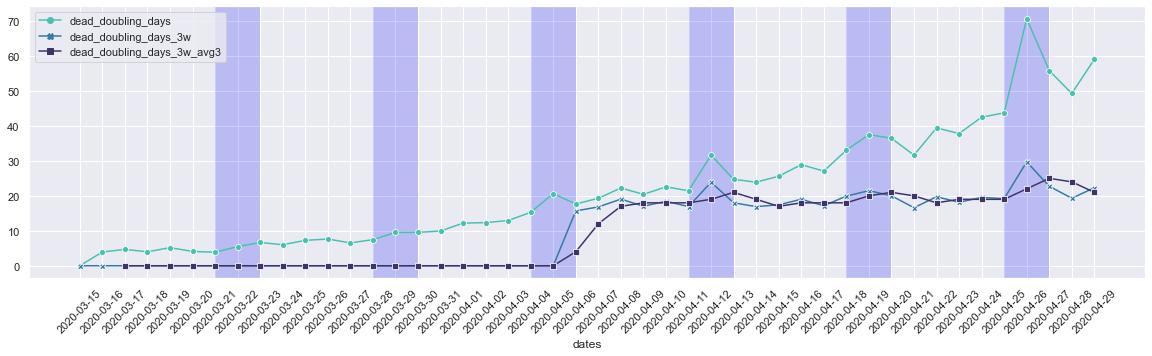

In [34]:
df_italy = prepare_df_country(dfcovid_conf_t, dfcovid_dead_t, 'Italy_nan', country_code='ITA',
                               date_cutoff='2020-03-15')
print_charts_country(df_italy)

# Compare Infections

In [35]:
def add_day_since(df, colunm, cutoff):
#     df = df_hamburg.loc[:,['confirmed']]
    df['day_since'] = 0
    df['day_since'] = df.apply(lambda x: x['day_since'] + 1 if x[colunm] > cutoff else 0, axis=1)
    df['day_since'] = df['day_since'].cumsum()
    return df

In [36]:
def join_series_day_since(dfs:dict, column):
    list_to_join = []
    for k in dfs.keys():
        df = dfs[k].loc[dfs[k].day_since > 0, [column] + ['day_since']]
        df.columns = [k] + ['day_since']
        df.set_index('day_since', inplace=True)
        list_to_join.append(df)
    
    return pd.concat(list_to_join, axis=1)

In [37]:
col = 'confirmed'
cnt = 10

df_hamburg = add_day_since(df_hamburg, col, cnt)
df_berlin = add_day_since(df_berlin, col, cnt)

df_sweden = add_day_since(df_sweden, col, cnt)
df_us = add_day_since(df_us, col, cnt)
df_uk = add_day_since(df_uk, col, cnt)
df_russia = add_day_since(df_russia, col, cnt)
df_germany = add_day_since(df_germany, col, cnt)
df_france = add_day_since(df_france, col, cnt)
df_spain = add_day_since(df_spain, col, cnt)
df_italy = add_day_since(df_italy, col, cnt)

countries = {
#             'Hamburg':df_hamburg,
             "Russia": df_russia,
             "UK": df_uk,
             "US": df_us,
             "Sweden": df_sweden,
             "Germany": df_germany,
             "France": df_france,
             "Spain": df_spain,
             "Italy": df_italy,
#              "Berlin": df_berlin,
             }

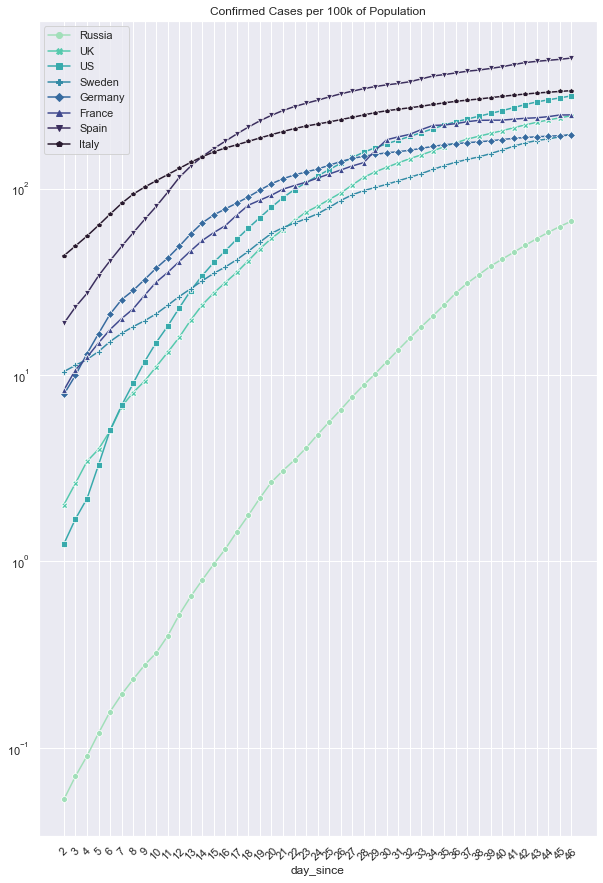

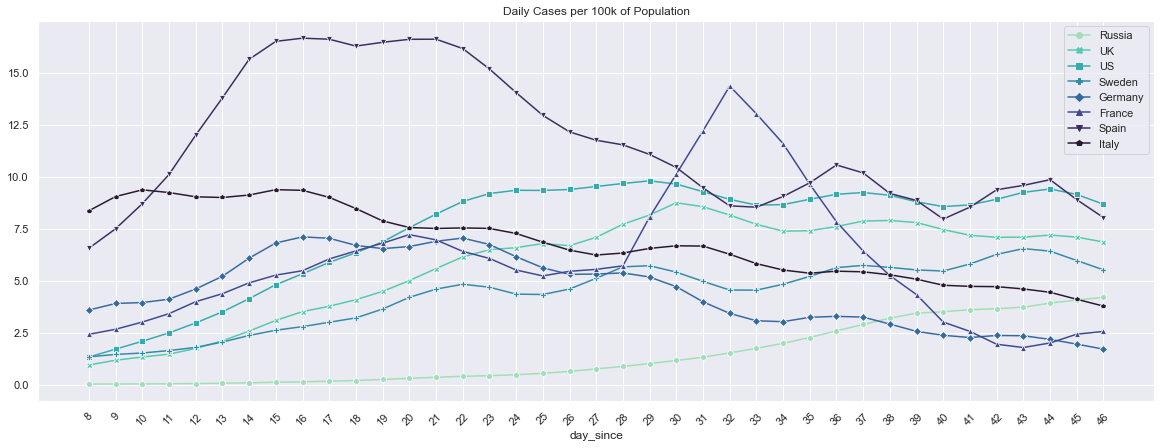

In [38]:
confirmed_per_100k = join_series_day_since(countries, 'confirmed_per_100k')
confirmed_change_per_100k = join_series_day_since(countries, 'confirmed_change_per_100k')

plot_line(confirmed_per_100k.rolling(2, win_type='triang').mean().dropna(), figsize=(10, 15),
          columns=list(countries.keys()), title='Confirmed Cases per 100k of Population', log_y=True)
plot_line(confirmed_change_per_100k.rolling(7, win_type='triang').mean().dropna(), figsize=(20, 7)
          , columns=list(countries.keys()), title='Daily Cases per 100k of Population')

---

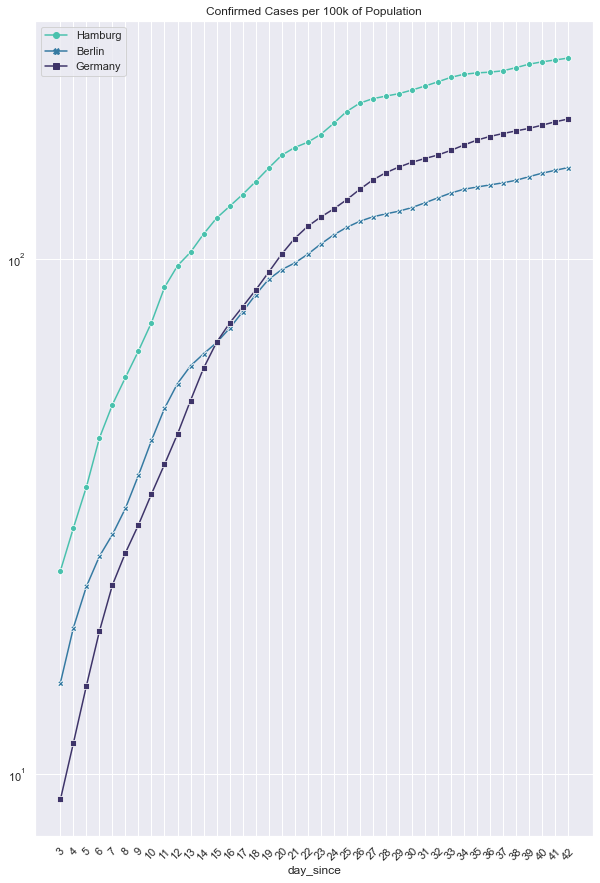

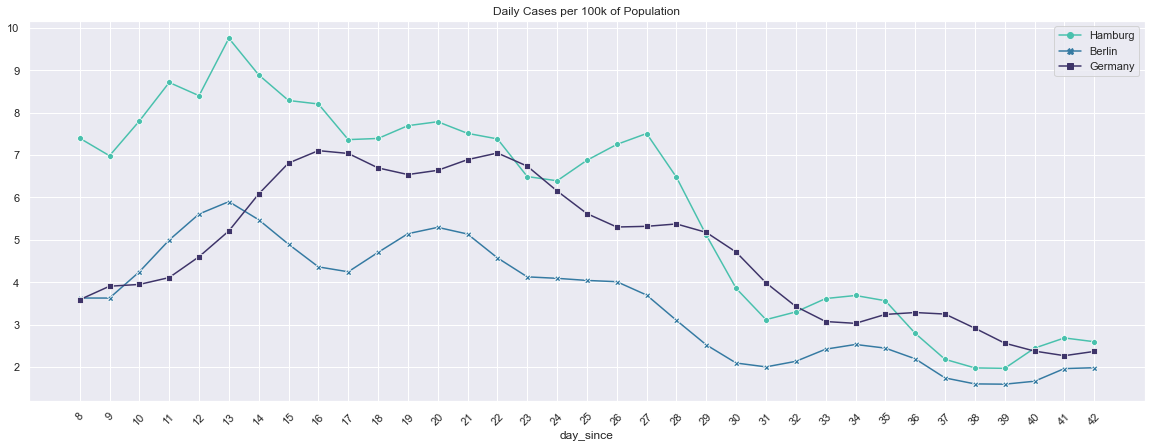

In [39]:
cities = {
             'Hamburg':df_hamburg,
             "Berlin": df_berlin,
             "Germany": df_germany,

             }

confirmed_per_100k = join_series_day_since(cities, 'confirmed_per_100k')
confirmed_change_per_100k = join_series_day_since(cities, 'confirmed_change_per_100k')

plot_line(confirmed_per_100k.rolling(3, win_type='triang').mean().dropna(), figsize=(10, 15),
          columns=list(cities.keys()), title='Confirmed Cases per 100k of Population', log_y=True)
plot_line(confirmed_change_per_100k.rolling(7, win_type='triang').mean().dropna(), figsize=(20, 7)
          , columns=list(cities.keys()), title='Daily Cases per 100k of Population')

---

## Join RKI and Mobility

In [40]:
df_joined = dfapple_region.join(df_hamburg)

In [41]:
# df_joined.loc['2020-03-18':'2020-03-30', ['change_%_conf','change_%_conf_avg3', 'transit', 'walking', 'driving']]